<a href="https://colab.research.google.com/github/ritzi12/gender-determination-using-eyes-image-cnn/blob/main/DPhi_Datathon_DLBootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gender Determination by Morphometry of Eyes**



> ##### **AUTHOR** : RITIKA GUPTA
> ##### *DPhi Profile Link:* https://dphi.tech/profile/ritika12/




## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [ ]:
import pandas as pd                                     # Data analysis and manipulation tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score
from google.colab.patches import cv2_imshow             #To display images in colab for jupyter use cv2.imshow() method

from tensorflow.keras.callbacks import TensorBoard      #Tensor Flow Visual Dashboard
import datetime                                         #Required to create log directory based on timestamp


In [ ]:
#Check GPUs 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading and preparing training data

Image Shape: (58, 58, 3)


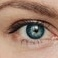

In [ ]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')


#Checking train images
imgg=cv2.imread(train_data['filepaths'][1], cv2.IMREAD_COLOR)
print("Image Shape:",imgg.shape)
cv2_imshow(imgg)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [ ]:
data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
train_images=np.asarray(np.zeros((len(train_data),image_size,image_size)))
for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  train_images[i]=new_img_array
  data.append([new_img_array, train_data['label'][i]])

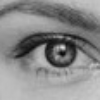

(100, 100)

In [ ]:
#Check image after greyscale conversion & resizing
cv2_imshow(data[1][0])
data[0][0].shape


## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [ ]:
train_labels= np.asarray([0 if x=='male' else 1 for x in labels['label']]) #converting categorical labels to numerical labels
label_name=['male','female']          #creating label name array based on numeric label assigned

#train_label_df=pd.DataFrame(train_labels,columns=['label'])
#print(train_label_df.head())

#Reshape
train_images=train_images.reshape(len(train_data),image_size,image_size,1)
print(train_images.shape)
#Normalize
train_images=train_images/255.0


(9220, 100, 100, 1)


## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [ ]:

INPUT_SHAPE=(image_size,image_size,1)
np.random.seed(seed=120)

#Define Model
def cnn_model():
    # define sequential model
  model = tf.keras.models.Sequential()
  # define conv-pool layers - set 1
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1),
  activation='relu', padding='same', input_shape=INPUT_SHAPE))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # define conv-pool layers - set 2
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), strides=(1, 1),
  activation='relu', padding='same', input_shape=INPUT_SHAPE))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
 # define conv-pool layers - set 3
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), 
  activation='relu', padding='same', input_shape=INPUT_SHAPE))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # define conv-pool layers - set 3
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(9, 9), strides=(1, 1), 
  activation='relu', padding='same', input_shape=INPUT_SHAPE))
 
  # add flatten layer
  model.add(tf.keras.layers.Flatten())

  # add dense layers with some dropout
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.BatchNormalization(axis=1))
  # add output layer
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  return model


In [ ]:
#Create Model
model=cnn_model()
# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       5

In [ ]:
# compile model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# Define Call Backs
EPOCHS = 100
#EarlyStop Callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
restore_best_weights=True,
verbose=1)

# Clear any logs from previous runs
!rm -rf ./logs/ 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
%load_ext tensorboard


In [ ]:
history = model.fit(train_images, train_labels,
batch_size=32,
callbacks=[es_callback,tensorboard_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

# Fetch Minimum Loss stored in  model history
loss = np.min(history.history['val_loss'])
print("Minimum Loss", loss)

Epoch 1/100
260/260 [==============================] - 47s 54ms/step - loss: 0.7912 - accuracy: 0.5263 - val_loss: 0.6813 - val_accuracy: 0.5542
Epoch 2/100
260/260 [==============================] - 12s 46ms/step - loss: 0.7210 - accuracy: 0.5365 - val_loss: 0.6915 - val_accuracy: 0.5488
Epoch 3/100
260/260 [==============================] - 12s 46ms/step - loss: 0.6889 - accuracy: 0.5512 - val_loss: 0.7509 - val_accuracy: 0.5488
Epoch 4/100
260/260 [==============================] - 12s 47ms/step - loss: 0.6824 - accuracy: 0.5717 - val_loss: 0.7818 - val_accuracy: 0.5488
Epoch 5/100
260/260 [==============================] - 12s 47ms/step - loss: 0.6661 - accuracy: 0.5985 - val_loss: 1.0862 - val_accuracy: 0.5488
Epoch 6/100
260/260 [==============================] - 12s 46ms/step - loss: 0.5817 - accuracy: 0.6970 - val_loss: 0.6953 - val_accuracy: 0.6041
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
Minimum Loss 0.6812728643417358


## Evaluation of Model

In [ ]:
%tensorboard --logdir logs/fit        #Magic Command Used to call TensorBoard 


<IPython.core.display.Javascript object>

### Save Model

We will save our trained model in the directory.

In [ ]:
#Make Directory to save Model
!mkdir -p saved_model


In [ ]:
model.save('saved_model/cnn_model_3')
!ls saved_model

In [ ]:
#Loading the model from saved location
loaded_model = tf.keras.models.load_model('saved_model/cnn_model_3')

# Check its architecture
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       5

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

Note: The Test Set doesn't contain labels only filenames.The predictions will be verified once the 'submission.csv' is uploaded.

In [ ]:
test_labels = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv")   # loading the test labels
file_paths = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in test_labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_data = pd.merge(images, labels, how = 'inner', on = 'filename')


image_size = 100      # image size taken is 100 here, one can take other size too
test_images=np.asarray(np.zeros((len(test_data),image_size,image_size))) #initialize numpy array

for i in range(len(test_data)):
  img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  test_images[i]=new_img_array


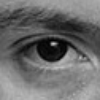

Test Images shape:
 (2305, 100, 100)


In [ ]:
#Check image after greyscale conversion & resizing
cv2_imshow(test_images[0])
print("Test Images shape:\n",test_images.shape)



## Data Pre-processing on Test Data

We reshape and normalize the test images similar to what we did in training set.

In [ ]:

#Reshape test_images array to (length of test data,100,100,1) 
test_images=test_images.reshape(len(test_data),image_size,image_size,1)
print("Test Images Shape: \n",test_images.shape)

#Normalize image array
test_images_scaled=test_images/255.0
print("\n Normalized/Scaled test images array \n",test_images_scaled[0])

## Predict Test Data
Time to predict test images using the model we trained. 

In [ ]:
#Predict Test labels
predictions = model.predict(test_images_scaled)
print("Predictions:\n ",predictions)

In [ ]:
#Convert prediction probabilities to class labels
output=np.asarray(np.zeros(len(test_data)),dtype='str')
for i in range(len(test_data)):
  output[i]=label_name[np.argmax(predictions[i])]

print("Prediction labels of Test Data: \n",output[0:5])  

## Save Predictions
We now convert our predictions into a pandas dataframe and write it as "submission.csv" .

In [ ]:
res = pd.DataFrame({'filename': test_labels['filename'], 'label': output})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False) 

# To download the csv file locally : Can skip this step in Jupyter
from google.colab import files        
files.download('submission.csv')